In [1]:
import pysnnblaze as pb
import numpy as np
import os

os.environ["CC"] = "gcc"
os.environ["CXX"] = "g++"

In [24]:
tau_m = 20e-3       # membrane time constant
v_rest = -70       # resting potential
v_reset = -70      # reset potential after spike
v_thresh = -50     # threshold
refractory = 5e-3   # refractory period

neuron = pb.LIFNeuron(tau_m=tau_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

## Testing a LIF Neuron
Remark that the neuron objects contain functions that manipulates an array representing the neuron states (membrane potentials in this case). However, it does not contain the state itself. 

In [25]:
# Testing a LIF Neuron

# Network state variables
state_arr = np.array([0], dtype=np.float64)
last_spike_arr = np.array([0], dtype=np.float64)

print(f'State at start: {state_arr}')
print(f'Last spike time at start: {last_spike_arr}')

# Neurons receives a spike of weight 1 at time 0
neuron.update(0., state_arr, last_spike_arr, 0.9)
print(f'State after receiving spike: {state_arr}')
print(f'Last spike time after receiving spike: {last_spike_arr}')

# Update neuron state after 1 time unit
neuron.update(1, state_arr, last_spike_arr, 0.)
print(f'State after 1 time unit: {state_arr}')
print(f'Last spike time after 1 time unit: {last_spike_arr}')

# Update neuron state to surpass threshold
neuron.update(2, state_arr, last_spike_arr, 100)
print(f'State after surpassing threshold: {state_arr}')
print(f'Last spike time after surpassing threshold: {last_spike_arr}')

State at start: [0.]
Last spike time at start: [0.]
State after receiving spike: [-70.]
Last spike time after receiving spike: [0.]
State after 1 time unit: [-70.]
Last spike time after 1 time unit: [0.]
State after surpassing threshold: [-70.]
Last spike time after surpassing threshold: [2.]


## Testing the state monitor

In [26]:
monitor = pb.SpikeMonitor()
monitor.on_spike(0, 2)
monitor.on_spike(1, 4)
monitor.on_spike(2, 5)
monitor.spike_list

[(0.0, 2), (1.0, 4), (2.0, 5)]

## Testing a Neural Network

In [27]:
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

# Spikes events with no synapses
nn.schedule_spike_event(0, 0, 100.)
nn.schedule_spike_event(2.2, 4, 100.)
nn.run(5.0)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


In [28]:
# Same experiment with 2 synapses 
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

syn1 = pb.Synapse(0, 1, 1.0, 100.0)
syn2 = pb.Synapse(4, 2, 1.0, 100.0)

nn.add_synapse(syn1)
nn.add_synapse(syn2)

nn.schedule_spike_event(0, 0, 100.0)
nn.schedule_spike_event(2.2, 4, 100.0)

nn.run(10)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


## Random neural network simulation

In [29]:
import random

# Parameters
num_neurons = 50
connection_prob = 0.2
weight_range_exc = (8, 8)  # Weight range for excitatory neurons
weight_range_inh = (-15, -15)  # Weight range for inhibitory neurons
delay_range = (0.001, 0.002)
inhibitory_ratio = 0.2
num_inhibitory = int(num_neurons * inhibitory_ratio)

# Generate the Erdős–Rényi random graph with random weights and delays
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            if random.random() < connection_prob:
                # Determine if the presynaptic neuron is inhibitory
                if pre >= num_neurons - num_inhibitory:
                    weight = random.uniform(*weight_range_inh)
                else:
                    weight = random.uniform(*weight_range_exc)
                delay = random.uniform(*delay_range)
                graph.append((pre, post, weight, delay))

# Generate spike events for all neurons and store them in a middle storage
# Parameters
spike_rate = 40.0  # spikes per second per neuron
t_start = 0.0
t_end = 5.0
input_neurons = 10
spike_storage = []
for neuron_id in range(input_neurons):
    t = t_start
    while t < t_end:
        # Inter-spike interval sampled from exponential distribution
        isi = random.expovariate(spike_rate)  # mean interval = 1 / spike_rate
        t += isi
        if t < t_end:
            magnitude = 30.0  # spike magnitude
            spike_storage.append((t, neuron_id, magnitude))

In [30]:
state_monitor = pb.StateMonitor(1e-3)

In [31]:
# Initialize network and monitor
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.set_state_monitor(state_monitor)
nn.add_neuron_population(num_neurons, neuron)
monitor.reset_spikes()

# Instantiate the graph into the neural network
for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

# Add the stored spike events to the schedule
for t, neuron_id, magnitude in spike_storage:
    nn.schedule_spike_event(t, neuron_id, magnitude)

# Run simulation
nn.run(.1)

# Output observed spikes
print(f'Number of events: {len(monitor.spike_list)}')
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Number of events: 37
Observed spike events (time, neuron id): [(0.0031738268112133823, 6), (0.003500017716821134, 1), (0.018230176220980714, 2), (0.020633651201011186, 1), (0.02159479343739563, 3), (0.023377517233856553, 8), (0.02847245895700473, 1), (0.02873454161341299, 5), (0.038011308839917456, 1), (0.04141291326118772, 3), (0.04494287979128582, 0), (0.05537970626972681, 0), (0.058076641994391, 6), (0.05872632232241565, 4), (0.058977842374878076, 9), (0.062478387993371916, 1), (0.06436931367962984, 2), (0.06439754526403274, 7), (0.06901465318513868, 6), (0.06962324923016683, 7), (0.07059859285197354, 5), (0.07414709002661371, 4), (0.07659588243801052, 8), (0.07740799417647168, 3), (0.07931822623697062, 7), (0.08043332460772966, 1), (0.08251560216429069, 5), (0.08377573129039767, 2), (0.08630310854621667, 0), (0.08917400838420346, 9), (0.09168969404815747, 7), (0.09299861634963268, 1), (0.09339264055169916, 5), (0.09512016634438547, 6), (0.09632907861685686, 3), (0.0966164704700026,

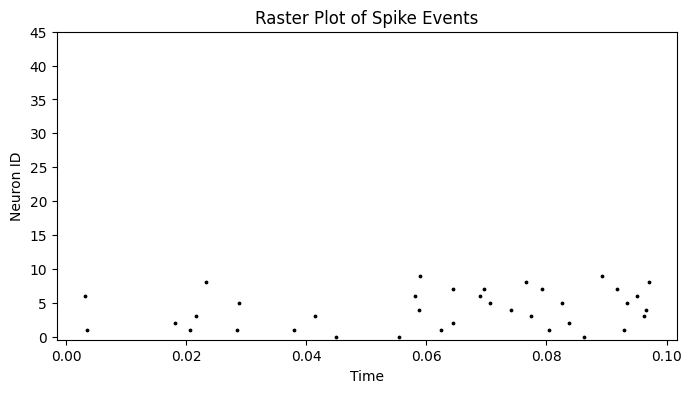

In [32]:
import matplotlib.pyplot as plt

# Plotting spike events
spike_times = [t for t, n in monitor.spike_list]
neuron_ids = [n for t, n in monitor.spike_list]

plt.figure(figsize=(8, 4))
plt.scatter(spike_times, neuron_ids, c='black', marker='o', s=3)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.title('Raster Plot of Spike Events')
plt.yticks(range(0, num_neurons, num_neurons//10))  # Show every 10th neuron ID
plt.show()

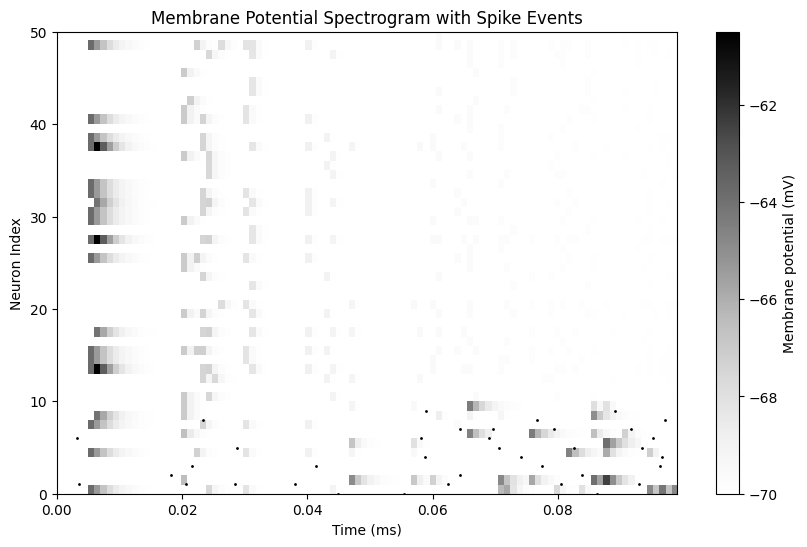

In [33]:
times = np.array([t for t, _ in state_monitor.state_vector_list])
states = np.array([vec for _, vec in state_monitor.state_vector_list])  # shape: (num_time_points, num_neurons)

# Transpose so neurons are on y-axis
states = states.T  # shape: (num_neurons, num_time_points)
num_neurons = states.shape[0]

plt.figure(figsize=(10, 6))
plt.imshow(states, aspect='auto', cmap='Greys', origin='lower',
           extent=[times[0], times[-1], 0, num_neurons])

# Overlay spike events
spike_times = [t for t, n in monitor.spike_list]
neuron_ids = [n for t, n in monitor.spike_list]
plt.plot(spike_times, neuron_ids, '.k', markersize=2, label='Spikes')

plt.colorbar(label='Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Spectrogram with Spike Events')
plt.show()

## Comparison to Brian 2

Number of spike events: 2363


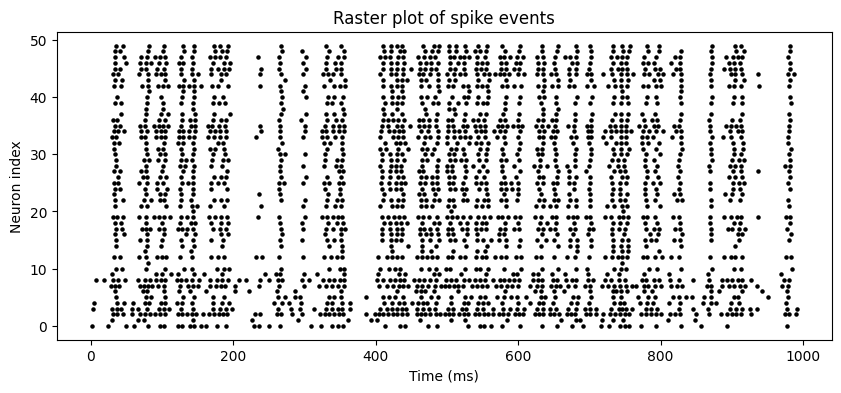

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# ==============================
# Parameters
# ==============================
# LIF neuron parameters
tau_m = 10*ms
v_rest = -70*mV
v_reset = -70*mV
v_thresh = -50*mV
refractory_period = 5*ms

eqs = '''
dv/dt = (v_rest - v) / tau_m : volt (unless refractory)
'''
G = NeuronGroup(num_neurons, eqs, threshold='v>v_thresh',
                reset='v=v_reset', refractory=refractory_period,
                method='exact')
G.v = v_rest

S = Synapses(G, G, 'w : volt', on_pre='v_post += w')

for pre, post, weight, delay in graph:
    S.connect(i=pre, j=post)
    S.w[pre, post] = weight*mV
    S.delay[pre, post] = delay*second

# Convert spike_storage → arrays
indices = np.array([neuron_id for _, neuron_id, _ in spike_storage])
times = np.array([t for t, _, _ in spike_storage]) * second

# Align times to simulation clock resolution
dt = defaultclock.dt
times = np.round(times / dt) * dt

# Remove duplicates (neuron, time) that would cause errors
pairs = set()
clean_indices, clean_times = [], []
for idx, t in zip(indices, times):
    if (idx, float(t)) not in pairs:
        pairs.add((idx, float(t)))
        clean_indices.append(idx)
        clean_times.append(t)

P = SpikeGeneratorGroup(input_neurons, indices=clean_indices, times=clean_times)
SP = Synapses(P, G, on_pre='v_post += 30*mV')  # input strength
SP.connect(i=np.arange(input_neurons), j=np.arange(input_neurons))

spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=True)  # record neuron 0 as example

run(1*second)

print(f"Number of spike events: {spikemon.num_spikes}")

# Raster plot
plt.figure(figsize=(10,4))
plt.scatter(spikemon.t/ms, spikemon.i, s=5, c='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of spike events')
plt.show()

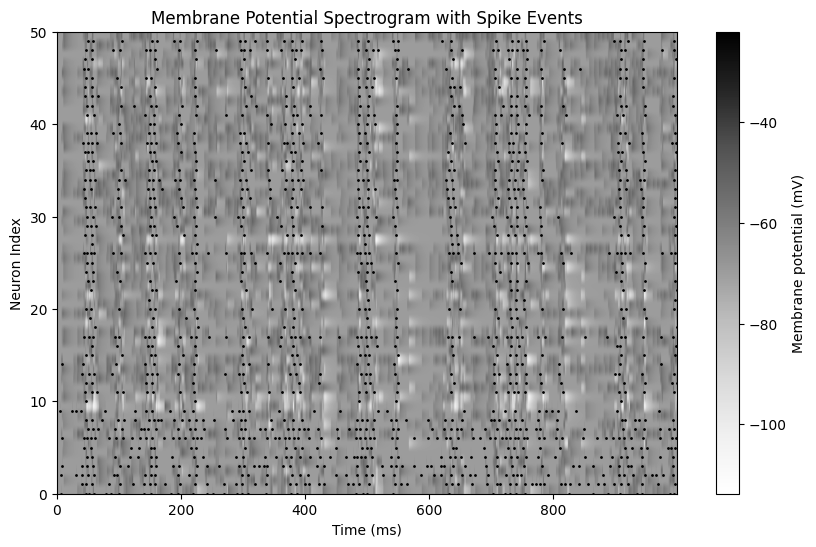

In [22]:

v_data = statemon.v / mV  # Convert to mV for easier visualization
time_data = statemon.t / ms  # Convert time to ms

plt.figure(figsize=(10, 6))
plt.imshow(v_data, aspect='auto', cmap='Greys', origin='lower', 
           extent=[time_data[0], time_data[-1], 0, num_neurons])

# Plot the spike events as dots
plt.plot(spikemon.t / ms, spikemon.i, '.k', markersize=2, label='Spikes')

# Add labels and color bar
plt.colorbar(label='Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Spectrogram with Spike Events')
plt.show()
